# Runnning sweep over distributions

In [2]:
import sys
sys.path.append('/Users/sstk4353/packages/WIPL_python_analysis/Complex_Multi_Body/')

#import WIPL_python_analysis.ComplexMultiBody.ComplexMultiBody as cmb
from ComplexMultiBody import ComplexMultiBody as cmb
from simulation_script import generate_distribution_df, run_simulation
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor, as_completed


np.random.seed(42)  # For reproducibility

sys.path.append('./')

Import generate dataset run simulation script 11 times, save datasets in dictionary

## Define plotting function

In [10]:
def plot_result(output_object, output_attribute, title_str, unit, plot_kwargs=None):

    fig, ax = plt.subplots(figsize=(10, 6))

    for run_id, output_object in output_object.items():
        output = getattr(output_object, output_attribute)

        p1, p2, size1, size2 = run_id.split('_')

        mixing_ratio = f'{p1}_{p2}'
        angles = np.arange(0,360, 2)

        ax.plot(angles, output, label=f'{int(float(p1)*10)}% 9mm {int(float(p2)*10)}% 17mm', linestyle = '--', **plot_kwargs)

    ax.set_xlabel('Azimuth (degrees)')
    ax.set_ylabel(title_str + f' ({unit})')
    ax.set_title(f'Variation in {title_str} with size mixing ratio')
    ax.legend()
    plt.grid()

    return fig, ax



## Default simulation parameters

In [7]:
radar_params = {
    'range_gate_separation': 600,  # meters
    'radar_beam_width': 1,  # degrees
    'range_of_observation': 150000,  # meters
    'beam_angle': 0.5,  # degrees
}

biological_params = {
    'density': 10e-5,  # scatterers per cubic meter
    'sizes': [9,17],  # size in mm
    'size_distribution': [0.7,0.3],  # not used in this example
    'mean_heading': 0,  # degrees
    'heading_spread': 20,  # degrees
    'mean_pitch': 11,  # degrees
    'pitch_spread': 10,  # degrees
}

In [7]:
scatterer_dataset = '/Users/sstk4353/packages/WIPL_python_analysis/Complex_Multi_Body/bioscatterer_database_v0.001.nc'
frequency = 5.6  # GHz

## Run simulations

In [ ]:
simulation_outputs = {}
run_id_list = []

for counter in range(0,11):
    prob_1 = counter / 10
    prob_2 = 1 - prob_1
    biological_params['size_distribution'] = [prob_1, prob_2]
    
    run_id = f"{prob_1}_{prob_2}_9_17"
    run_id_list.append(run_id)

    df = generate_distribution_df(radar_params, biological_params, run_id, save =False)
    CMB = run_simulation(df, xr.open_dataset(scatterer_dataset), frequency=frequency)
    simulation_outputs[run_id] = CMB





Radar beam radius: 1308.996938995747 m
Radar volume size: 3229820487.531231 m^3
Estimated number of scatterers: 322982
Spacing between scatterers: 21.544346900318832 m
Radar beam radius: 1308.996938995747 m
Radar volume size: 3229820487.531231 m^3
Estimated number of scatterers: 322982
Spacing between scatterers: 21.544346900318832 m
Radar beam radius: 1308.996938995747 m
Radar volume size: 3229820487.531231 m^3
Estimated number of scatterers: 322982
Spacing between scatterers: 21.544346900318832 m
Radar beam radius: 1308.996938995747 m
Radar volume size: 3229820487.531231 m^3
Estimated number of scatterers: 322982
Spacing between scatterers: 21.544346900318832 m
Radar beam radius: 1308.996938995747 m
Radar volume size: 3229820487.531231 m^3
Estimated number of scatterers: 322982
Spacing between scatterers: 21.544346900318832 m
Radar beam radius: 1308.996938995747 m
Radar volume size: 3229820487.531231 m^3
Estimated number of scatterers: 322982
Spacing between scatterers: 21.5443469003

## Trying to run simulations in parallel

I should write this as a script so I can parallelise it properly

In [12]:
def single_run(counter, radar_params, biological_params, scatterer_dataset, frequency):
    # Local copy of biological_params to avoid race conditions
    bio_params = biological_params.copy()
    prob_1 = counter / 10
    prob_2 = 1 - prob_1
    bio_params['size_distribution'] = [prob_1, prob_2]
    
    run_id = f"{prob_1}_{prob_2}_9_17"

    # Generate distribution dataframe
    df = generate_distribution_df(radar_params, bio_params, run_id, save=False)
    
    # Run simulation
    CMB = run_simulation(df, xr.open_dataset(scatterer_dataset), frequency=frequency)
    
    return run_id, CMB

def run_parallel_simulations(radar_params, biological_params, scatterer_dataset, frequency):
    simulation_outputs = {}
    run_id_list = []

    # Use ProcessPoolExecutor for CPU-bound work
    with ThreadPoolExecutor() as executor:
        futures = {
            executor.submit(single_run, counter, radar_params, biological_params, scatterer_dataset, frequency): counter
            for counter in range(0, 11)
        }

        for future in as_completed(futures):
            run_id, CMB = future.result()
            simulation_outputs[run_id] = CMB
            run_id_list.append(run_id)

    return simulation_outputs, run_id_list

# Example usage
simulation_outputs, run_id_list = run_parallel_simulations(
    radar_params, biological_params, scatterer_dataset, frequency
)

Radar beam radius: 1308.996938995747 m
Radar volume size: 3229820487.531231 m^3
Estimated number of scatterers: 322982
Spacing between scatterers: 21.544346900318832 m
Radar beam radius: 1308.996938995747 m
Radar volume size: 3229820487.531231 m^3
Estimated number of scatterers: 322982
Spacing between scatterers: 21.544346900318832 m
Radar beam radius: 1308.996938995747 m
Radar volume size: 3229820487.531231 m^3
Estimated number of scatterers: 322982
Spacing between scatterers: 21.544346900318832 m
Radar beam radius: 1308.996938995747 m
Radar volume size: 3229820487.531231 m^3
Estimated number of scatterers: 322982
Spacing between scatterers: 21.544346900318832 m
Radar beam radius: 1308.996938995747 m
Radar volume size: 3229820487.531231 m^3
Estimated number of scatterers: 322982
Spacing between scatterers: 21.544346900318832 m
Radar beam radius: 1308.996938995747 m
Radar volume size: 3229820487.531231 m^3
Estimated number of scatterers: 322982
Spacing between scatterers: 21.5443469003

In [52]:
sorted_simulations_outputs = {run_id: simulation_outputs[run_id] for run_id in sorted(run_id_list, reverse=True)}

In [13]:
run_id_list = []

for counter in range(0,11):
    counter_complement = 10 - counter

    run_id = f"{counter}_{counter_complement}_9_17"
    run_id_list.append(run_id)

#run_id_list = sorted(run_id_list, reverse=True)

In [14]:
base_file_path = '/Users/sstk4353/packages/WIPL_python_analysis/Complex_Multi_Body/simulation_sweeps/outputs/size_sweep/'

In [15]:
loaded_simulation_outputs = {run_id : pd.read_csv(base_file_path + run_id +'.csv') for run_id in run_id_list}

In [16]:
loaded_simulation_outputs[run_id_list[0]].head()

,Unnamed: 0,azimuth,differential_reflectivity,differential_phase,horizontal_power,vertical_power,resultant_voltage_phi,resultant_voltage_theta,frequency
0,0,0,1.671655,-10.651200,19.288445,13.125979,(4.391284509786599+0.07117334758735384j),(3.549237987078649+0.7272474462242771j),5.6
1,1,2,1.820257,-11.681758,18.362983,12.075845,(4.281863335747513+0.16920225650049053j),(3.3726184100444496+0.8374304655417889j),5.6
2,2,4,2.047538,-13.184025,17.844670,11.136654,(4.2173200711684835+0.242655613518658j),(3.2001164313555526+0.946524847482304j),5.6
3,3,6,2.350907,-15.202139,17.703722,10.303241,(4.197455643030381+0.29169802838998693j),(3.031736809051922+1.0544254164829385j),5.6
4,4,8,2.725290,-17.754533,17.925001,9.570401,(4.221940959945256+0.3165678261945622j),(2.867478801841685+1.1610195579373441j),5.6


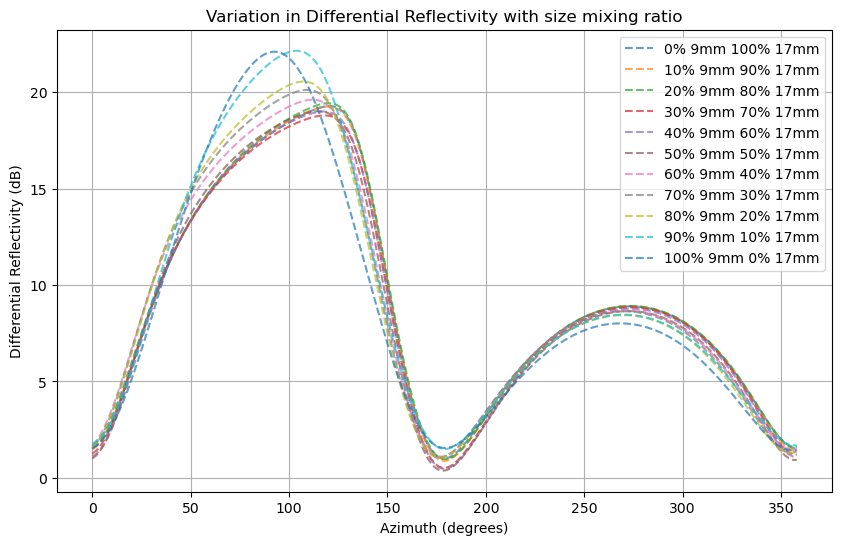

In [17]:
fig, ax = plot_result(loaded_simulation_outputs, 'differential_reflectivity', 'Differential Reflectivity', 'dB', plot_kwargs={'alpha': 0.7})

In [ ]:
fig.savefig('./size_sweep_plots/size_sweep_9_17_zdr.svg')

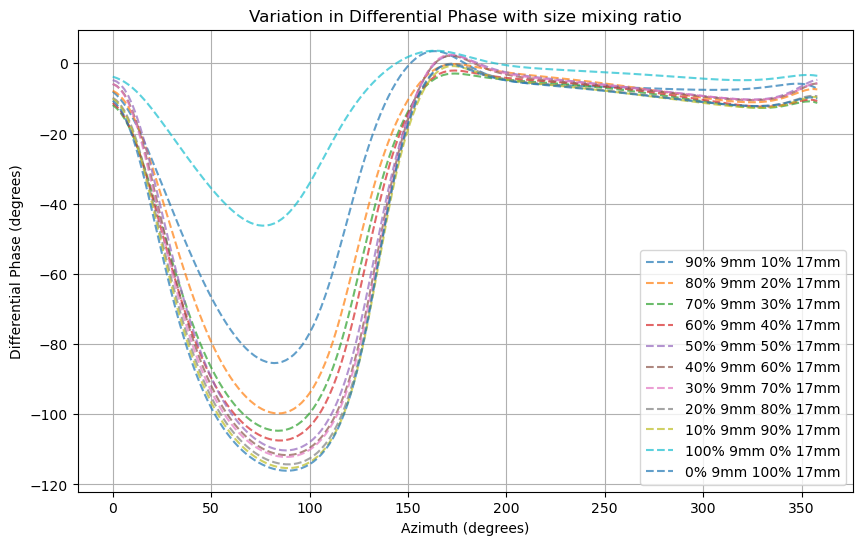

In [37]:
fig, ax = plot_result(loaded_simulation_outputs, 'differential_phase', 'Differential Phase',  'degrees', plot_kwargs={'alpha': 0.7})

In [38]:
fig.savefig('./size_sweep_plots/size_sweep_9_17_phidp.svg')

## Fig for AMS poster

In [37]:
print(run_id_list)

['0_10_9_17', '1_9_9_17', '2_8_9_17', '3_7_9_17', '4_6_9_17', '5_5_9_17', '6_4_9_17', '7_3_9_17', '8_2_9_17', '9_1_9_17', '10_0_9_17']


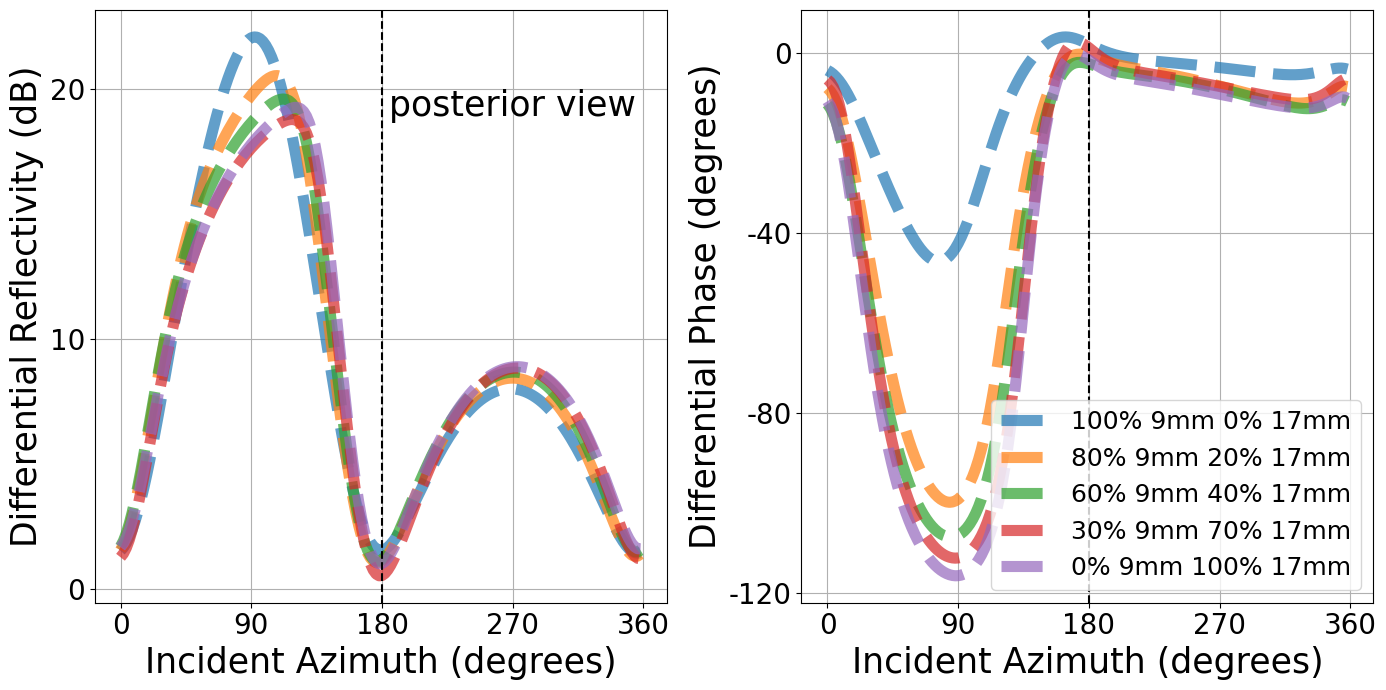

In [48]:
fig, axes = plt.subplots(1,2, figsize=(14,7))
alpha = 0.7

sub_list = reversed(['0_10_9_17', '3_7_9_17',  '6_4_9_17',  '8_2_9_17',  '10_0_9_17'])

fontsize=25
linewidth=8

for run_id in sub_list:

    output_object = loaded_simulation_outputs[run_id]


    p1, p2, size1, size2 = run_id.split('_')

    mixing_ratio = f'{p1}_{p2}'
    angles = np.arange(0,360, 2)

    zdr = getattr(output_object, 'differential_reflectivity')
    phidp = getattr(output_object, 'differential_phase')

    axes[0].plot(angles, zdr, label=f'{int(float(p1)*10)}% 9mm {int(float(p2)*10)}% 17mm', linestyle = '--', alpha = alpha, linewidth=linewidth)#, **plot_kwargs)
    axes[1].plot(angles, phidp, label=f'{int(float(p1)*10)}% 9mm {int(float(p2)*10)}% 17mm', linestyle = '--', alpha= alpha, linewidth=linewidth)#, **plot_kwargs)


for ax in axes:
    # Draw the vertical line
    ax.axvline(x=180, linestyle='--', color='black')
    
    # Get current y-limits to place text in the middle
    y_min, y_max = ax.get_ylim()
    y_pos = y_max - (y_max - y_min) * 0.1  # 10% below top

    # Add text label near the line
    #ax.text(185, y_pos-10, 'posterior view', rotation=0, va='top', ha='left', color='black')
    ax.grid()

axes[0].text(185, 20, 'posterior view', rotation=0, va='top', ha='left', color='black', fontsize=fontsize)

axes[1].legend(fontsize=18)
axes[0].set_ylabel('Differential Reflectivity (dB)', fontsize =fontsize)
axes[0].set_xlabel('Incident Azimuth (degrees)', fontsize =fontsize)
axes[1].set_xlabel('Incident Azimuth (degrees)', fontsize =fontsize)
axes[1].set_ylabel('Differential Phase (degrees)', fontsize =fontsize)



#fig.suptitle('Sensitivity of the dual-polarisation scattering properties to differential phase on transmission with 10 degree pitch',fontsize=13)

for ax in axes:
    ax.set_xticks([0,90,180,270,360])                      # positions
    ax.set_xticklabels([0,90,180,270,360], fontsize=20)    # labels + fontsize

axes[1].set_yticks([-120,-80,-40,0])
axes[1].set_yticklabels([-120,-80,-40,0], fontsize=20)  

axes[0].set_yticks([0, 10,  20])
axes[0].set_yticklabels([-0, 10, 20], fontsize=20)  

fig.tight_layout()

fig.savefig('./size_sweep_plots/for_AMS_v2.svg')


